In [1]:
# Load packages
import pandas as pd
import numpy as np
from datetime import date
from tqdm import tqdm
import plotly.graph_objects as go
import telegram_send
import paneleventstudy as es

In [2]:
# Preliminaries
df = pd.read_stata('https://github.com/scunning1975/mixtape/raw/master/baker.dta')  # from scott cunningham's Mixtape
col_bareminimum = ['id', 'year', 'treat', 'y']  # the sort of data one starts working with in a panel event study setup
df = df[col_bareminimum].reset_index(drop=True)  # reset index
df.head()

,id,year,treat,y
0,1.0,1980.0,0.0,1.304093
1,1.0,1981.0,0.0,2.123511
2,1.0,1982.0,0.0,3.631350
3,1.0,1983.0,0.0,4.147669
4,1.0,1984.0,0.0,5.160839


In [3]:
# Check if input data is a balanced panel
check_balancepanel = es.balancepanel(
    data=df,
    group='id',
    event='treat',
    calendartime='year'
)
if check_balancepanel:
    print('Panel is balanced! Proceed.')
elif not check_balancepanel:
    raise NotImplementedError('Panel is not balanced! Pls fix tqvm.')


Checks if input data frame is a BALANCED PANEL
Checking if every group has the same number of observations
Every group has the same number of observations
Checking min and max of calendartime by groups (ONLY for datetime/int)
Checking if the smallest calendartime is the same for all groups (ONLY for datetime/int)
Every group has the same minimum calendartime value
Checking if the largest calendartime is the same for all groups (ONLY for datetime/int)
Every group has the same maximum calendartime value
Panel is balanced! Proceed.


In [4]:
# Flag control groups (generate new column: control_group)
df = es.identifycontrols(
    data=df,
    group='id',
    event='treat'
) 
df.head()


Identifying control groups: never-treated, or last-treated
Generates new indicator column: control_group
Finding never-treated groups
No never-treated groups exist, proceeding to find last-treated groups


,id,year,treat,y,control_group
0,1.0,1980.0,0.0,1.304093,0
1,1.0,1981.0,0.0,2.123511,0
2,1.0,1982.0,0.0,3.631350,0
3,1.0,1983.0,0.0,4.147669,0
4,1.0,1984.0,0.0,5.160839,0


In [5]:
# Generates relative time column called 'reltime'
df = es.genreltime(
    data=df,
    group='id',
    event='treat',
    calendartime='year',
    reltime='reltime',
    check_balance=True
)  
df.head()


Generating relative time columns from event column; time0 = when treatment is applied
To generalise, calendartime's format will be ignored
PLEASE ensure that calendartime is ascending without gaps, i.e., T-k, T-k+1, ..., T, ..., T+k
Input dataframe must be a BALANCED PANEL
Relative time will be stored in reltime

Checks if input data frame is a BALANCED PANEL
Checking if every group has the same number of observations
Every group has the same number of observations
NOT checking min and max of calendartime by groups
Quick check indicates panel is balanced
All groups without events have reltime filled with 0


,id,year,treat,y,control_group,reltime
0,1.0,1980.0,0.0,1.304093,0,-6
1,1.0,1981.0,0.0,2.123511,0,-5
2,1.0,1982.0,0.0,3.631350,0,-4
3,1.0,1983.0,0.0,4.147669,0,-3
4,1.0,1984.0,0.0,5.160839,0,-2


In [6]:
# Generates cohort column called 'cohort'
df = es.gencohort(
    data=df,
    group='id',
    event='treat',
    calendartime='year',
    cohort='cohort',
    check_balance=True
) 
df.head()


Generating cohort indicators
To generalise, calendartime's format will be ignored
PLEASE ensure that calendartime is ascending without gaps, i.e., T-k, T-k+1, ..., T, ..., T+k
Input dataframe must be a BALANCED PANEL
Cohort indicators will be stored in cohort

Checks if input data frame is a BALANCED PANEL
Checking if every group has the same number of observations
Every group has the same number of observations
NOT checking min and max of calendartime by groups
Quick check indicates panel is balanced
All groups without events have cohort filled with -1


,id,year,treat,y,control_group,reltime,cohort
0,1.0,1980.0,0.0,1.304093,0,-6,6
1,1.0,1981.0,0.0,2.123511,0,-5,6
2,1.0,1982.0,0.0,3.631350,0,-4,6
3,1.0,1983.0,0.0,4.147669,0,-3,6
4,1.0,1984.0,0.0,5.160839,0,-2,6


In [7]:
# Generates a new column called 'ct' containing the numerics version of calendar time 'year'
df = es.gencalendartime_numerics(
    data=df,
    group='id',
    event='treat',
    calendartime='year',
    calendartime_numerics='ct'
)  
df.head()


Generating numerics calendar time from 0 to T (end of time)
Intended to make calling PanelOLS dependencies later easier by bypassing the datetime requirement
PLEASE ensure that calendartime is ascending without gaps, i.e., T-k, T-k+1, ..., T, ..., T+k
Input dataframe must be a BALANCED PANEL

Checks if input data frame is a BALANCED PANEL
Checking if every group has the same number of observations
Every group has the same number of observations
NOT checking min and max of calendartime by groups
Quick check indicates panel is balanced


,id,year,treat,y,control_group,reltime,cohort,ct
0,1.0,1980.0,0.0,1.304093,0,-6,6,0
1,1.0,1981.0,0.0,2.123511,0,-5,6,1
2,1.0,1982.0,0.0,3.631350,0,-4,6,2
3,1.0,1983.0,0.0,4.147669,0,-3,6,3
4,1.0,1984.0,0.0,5.160839,0,-2,6,4


In [8]:
# Estimate naive TWFE event study regression model
est_twfe = es.naivetwfe_eventstudy(
    data=df,
    outcome='y',
    event='treat',
    group='id',
    reltime='reltime',
    calendartime='ct',
    covariates=[],
    vcov_type='robust',
    check_balance=True
)
est_twfe.head()


Estimates a naive event study regression using dynamic TWFE
Ensure that reltime is int, with -1 = one period before treatment onset
Returns a dataframe containing the lead-lag coefficients and CIs

Checks if input data frame is a BALANCED PANEL
Checking if every group has the same number of observations
Every group has the same number of observations
NOT checking min and max of calendartime by groups
Quick check indicates panel is balanced
Estimating equation: y ~ 1 + C(reltime) + EntityEffects + TimeEffects


D:\Users\ECSUAH\Desktop\Quant\Playground\venv\lib\site-packages\paneleventstudy\naivetwfe_eventstudy.py:49: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

C(reltime)[T.18], C(reltime)[T.19], C(reltime)[T.20], C(reltime)[T.21], C(reltime)[T.22], C(reltime)[T.23]

  res = mod.fit(cov_type=vcov_type)


,parameter,lower,upper
index,,,
-24,267.327706,266.433398,268.222014
-23,253.322726,252.434152,254.211301
-22,239.338570,238.454412,240.222727
-21,225.284789,224.395103,226.174475
-20,211.358086,210.457078,212.259093



Takes output from est_ functions to plot event study estimates and their CIs
Requires 3 columns: parameter, lower, and upper; indexed to relative time
Output = plotly graph objects figure


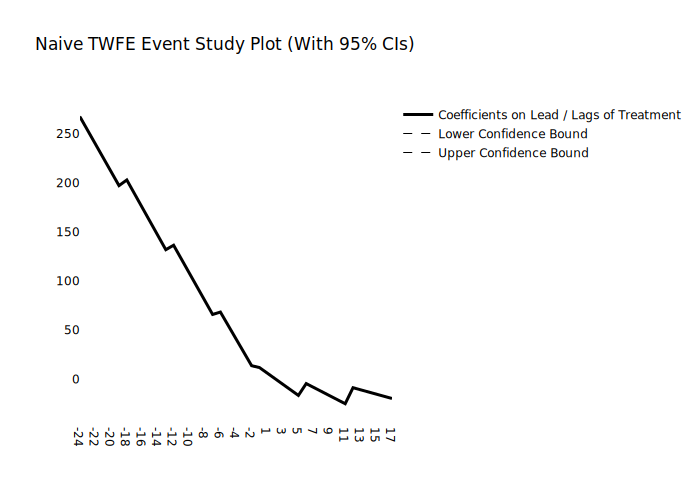

In [9]:
# Plot the estimated TWFE event study lead lag coefficients
fig_twfe = es.eventstudyplot(
    input=est_twfe,
    big_title='Naive TWFE Event Study Plot (With 95% CIs)',
    name_output='eventstudyplot_twfe'
)
fig_twfe.show('svg')

In [10]:
# Estimate interaction-weighted event study regression model
est_iw = es.interactionweighted_eventstudy(
    data=df,
    outcome='y',
    event='treat',
    group='id',
    cohort='cohort',
    reltime='reltime',
    calendartime='ct',
    covariates=[],
    vcov_type='robust',
    check_balance=True
)
est_iw.head()


Estimates an interaction-weighted event study regression as in Sun and Abraham (2021)
Ensure that reltime is int, with -1 = one period before treatment onset
Returns a dataframe containing the lead-lag coefficients and CIs
This version: vanilla off-the-shelf HAC-robust CIs

Checks if input data frame is a BALANCED PANEL
Checking if every group has the same number of observations
Every group has the same number of observations
NOT checking min and max of calendartime by groups
Quick check indicates panel is balanced


D:\Users\ECSUAH\Desktop\Quant\Playground\venv\lib\site-packages\paneleventstudy\interactionweighted_eventstudy.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\Users\ECSUAH\Desktop\Quant\Playground\venv\lib\site-packages\paneleventstudy\interactionweighted_eventstudy.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\Users\ECSUAH\Desktop\Quant\Playground\venv\lib\site-packages\paneleventstudy\interactionweighted_eventstudy.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of

Estimating equation: y ~ C(reltime):C(cohort)

Checks if RHS columns in data are linearly independent
Will trim columns that are linearly dependent
Later columns get precedence
Returns a list of columns that are linearly dependent, and should be dropped
Intercept label given; intercept column will be given precedence
Transforming input matrix into reduced row echelon form
The following columns were dropped due to linear dependence:
C(reltime)[T.12]:C(cohort)[24], C(reltime)[T.-17]:C(cohort)[6], C(reltime)[T.-23]:C(cohort)[18], C(reltime)[T.19]:C(cohort)[18], C(reltime)[T.-23]:C(cohort)[6], C(reltime)[T.14]:C(cohort)[24], C(reltime)[T.-24]:C(cohort)[6], C(reltime)[T.22]:C(cohort)[12], C(reltime)[T.12]:C(cohort)[18], C(reltime)[T.10]:C(cohort)[24], C(reltime)[T.-15]:C(cohort)[6], C(reltime)[T.-9]:C(cohort)[6], C(reltime)[T.14]:C(cohort)[18], C(reltime)[T.-11]:C(cohort)[6], C(reltime)[T.17]:C(cohort)[24], C(reltime)[T.20]:C(cohort)[24], C(reltime)[T.-22]:C(cohort)[12], C(reltime)[T.-22]:C

D:\Users\ECSUAH\Desktop\Quant\Playground\venv\lib\site-packages\paneleventstudy\interactionweighted_eventstudy.py:119: AbsorbingEffectWarning:


Variables have been fully absorbed and have removed from the regression:

C(cohort)[T.12], C(cohort)[T.18], C(cohort)[T.24], C(reltime)[T.-24]:C(cohort)[24], C(reltime)[T.-23]:C(cohort)[24], C(reltime)[T.-22]:C(cohort)[24], C(reltime)[T.-21]:C(cohort)[24], C(reltime)[T.-20]:C(cohort)[24], C(reltime)[T.-19]:C(cohort)[24], C(reltime)[T.-18]:C(cohort)[24], C(reltime)[T.-17]:C(cohort)[24], C(reltime)[T.-16]:C(cohort)[24], C(reltime)[T.-15]:C(cohort)[24], C(reltime)[T.-14]:C(cohort)[24], C(reltime)[T.-13]:C(cohort)[24], C(reltime)[T.-12]:C(cohort)[24], C(reltime)[T.-11]:C(cohort)[24], C(reltime)[T.-10]:C(cohort)[24], C(reltime)[T.-9]:C(cohort)[24], C(reltime)[T.-8]:C(cohort)[24], C(reltime)[T.-7]:C(cohort)[24], C(reltime)[T.-6]:C(cohort)[24], C(reltime)[T.-5]:C(cohort)[24], C(reltime)[T.-4]:C(cohort)[24], C(reltime)[T.-3]:C(cohort)[24], C(reltime)[

,parameter,lower,upper
reltime,,,
-18,-0.038471,-0.100628,0.023685
-17,0.021377,-0.042925,0.085679
-16,-0.016810,-0.080300,0.046681
-15,0.044857,-0.015783,0.105498
-14,0.010992,-0.054050,0.076034



Takes output from est_ functions to plot event study estimates and their CIs
Requires 3 columns: parameter, lower, and upper; indexed to relative time
Output = plotly graph objects figure


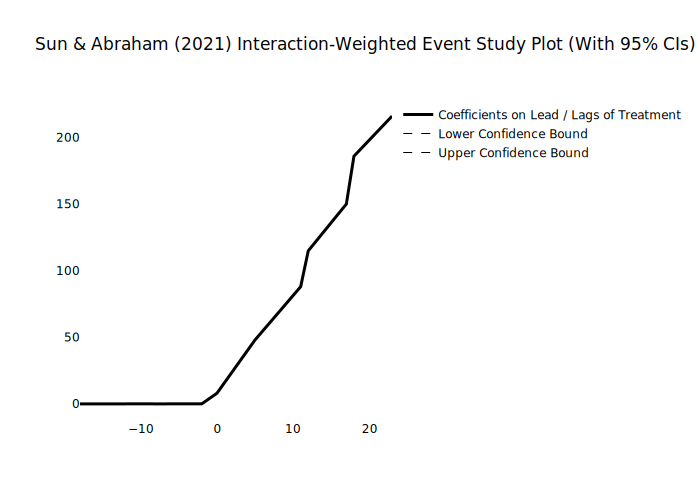

In [11]:
# Plot the estimated interaction-weighted event study coefficients
fig_iw = es.eventstudyplot(
    input=est_iw,
    big_title='Sun & Abraham (2021) Interaction-Weighted Event Study Plot (With 95% CIs)',
    name_output='eventstudyplot_iw'
)
fig_iw.show('svg')

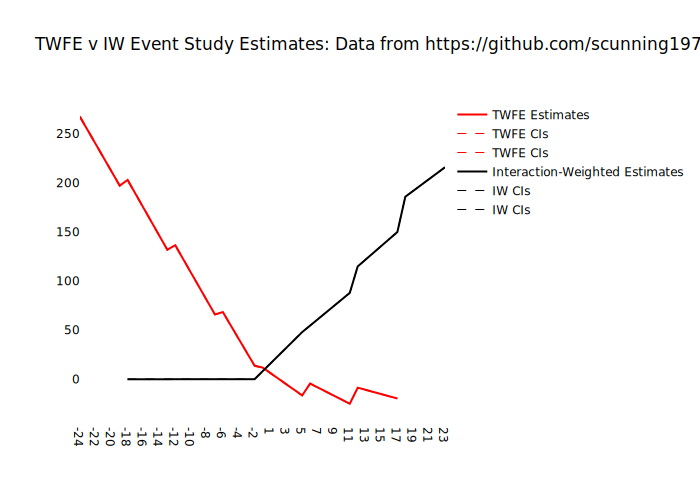

In [12]:
# Plot both the TWFE and interaction-weighted event study coefficients
option_ci = 1 # option to plot CIs as well
fig = go.Figure()
# TWFE
fig.add_trace(
    go.Scatter(
        x=est_twfe.index,
        y=est_twfe['parameter'],
        name='TWFE Estimates',
        mode='lines',
        line=dict(color='red', width=2)
    )
)
if option_ci == 1:
    fig.add_trace(
            go.Scatter(
                x=est_twfe.index,
                y=est_twfe['lower'],
                name='TWFE CIs',
                mode='lines',
                line=dict(color='red', width=1, dash='dash')
            )
        )
    fig.add_trace(
            go.Scatter(
                x=est_twfe.index,
                y=est_twfe['upper'],
                name='TWFE CIs',
                mode='lines',
                line=dict(color='red', width=1, dash='dash')
            )
        )
# IW
fig.add_trace(
    go.Scatter(
        x=est_iw.index,
        y=est_iw['parameter'],
        name='Interaction-Weighted Estimates',
        mode='lines',
        line=dict(color='black', width=2)
    )
)
if option_ci == 1:
    fig.add_trace(
            go.Scatter(
                x=est_iw.index,
                y=est_iw['lower'],
                name='IW CIs',
                mode='lines',
                line=dict(color='black', width=1, dash='dash')
            )
        )
    fig.add_trace(
            go.Scatter(
                x=est_iw.index,
                y=est_iw['upper'],
                name='IW CIs',
                mode='lines',
                line=dict(color='black', width=1, dash='dash')
            )
        )
# Overall layout
fig.update_layout(
    title='TWFE v IW Event Study Estimates: Data from https://github.com/scunning1975/mixtape/baker.dta',
    plot_bgcolor='white',
    font=dict(color='black')
)
fig.show('svg')  # display final plot